In [140]:
import astropy
from astropy.io import fits
from astropy.table import Table
import matplotlib.pylab as plt
import numpy as np
import scipy.interpolate
from scipy.interpolate import splev, splrep
from scipy.optimize import curve_fit

# Updates

The "gaussian" update is the last cell of this notebook. I need to investigate more on this becasue I realized these spectral lines don't look gaussian much. They look like inverted gaussians. Let's say we inverted these spectral lines, even then, it does not look like gaussians. I need more time to investigate. I know my gaussian function works. 



In [141]:
%matplotlib inline
from astropy.io import fits
star = 'tauceti'
#This is data for Tau Ceti
#ESPRESSO
taudata = fits.open('ADP.2021-04-13T13:26:21.329.fits')
taudata.info()
image_data = taudata[0].data # Get the data associated with the HDU, same as for a table
print(taudata[1].columns)
evt_data = Table(taudata[1].data)            
print(evt_data)
print(evt_data['WAVE'].data)

Filename: ADP.2021-04-13T13:26:21.329.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1677   ()      
  1  SPECTRUM      1 BinTableHDU     86   1R x 12C   [443262D, 443262D, 443262D, 443262J, 443262D, 443262D, 443262D, 443262D, 443262J, 443262D, 443262D, 443262J]   
ColDefs(
    name = 'WAVE'; format = '443262D'; unit = 'angstrom'
    name = 'FLUX'; format = '443262D'; unit = 'erg.cm**(-2).s**(-1).angstrom**(-1)'
    name = 'ERR'; format = '443262D'; unit = 'erg.cm**(-2).s**(-1).angstrom**(-1)'
    name = 'QUAL'; format = '443262J'
    name = 'SNR'; format = '443262D'
    name = 'WAVE_AIR'; format = '443262D'; unit = 'angstrom'
    name = 'FLUX_EL'; format = '443262D'
    name = 'ERR_EL'; format = '443262D'
    name = 'QUAL_EL'; format = '443262J'
    name = 'FLUX_CAL'; format = '443262D'; unit = 'erg.s**(-1).cm**(-2)*angstrom**(-1)'
    name = 'ERR_CAL'; format = '443262D'; unit = 'erg.s**(-1).cm**(-2)*angstrom**(-1)'
    name = 'Q

Text(0.5, 1.0, 'Tau Ceti')

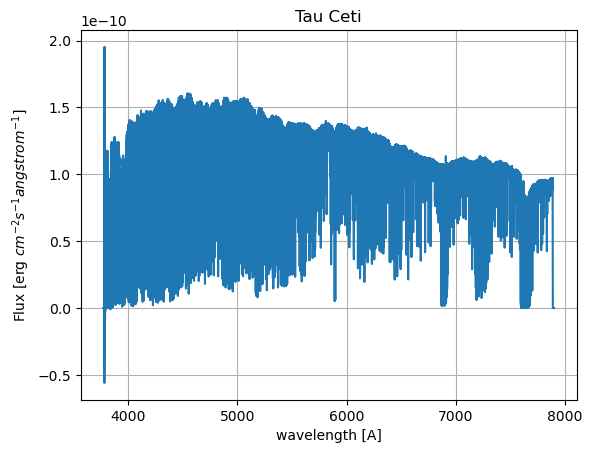

In [142]:
#This is for all of data plotted, not normalized
plt.plot(evt_data['WAVE'][0][:],evt_data['FLUX'][0][:])
plt.grid()
plt.xlabel('wavelength [A]')
plt.ylabel('Flux [erg $cm^{-2}$$s^{-1}$$angstrom^{-1}$]')
plt.title('Tau Ceti')

Text(0.5, 1.0, 'Not Normolized Sodium D Spectral Lines ')

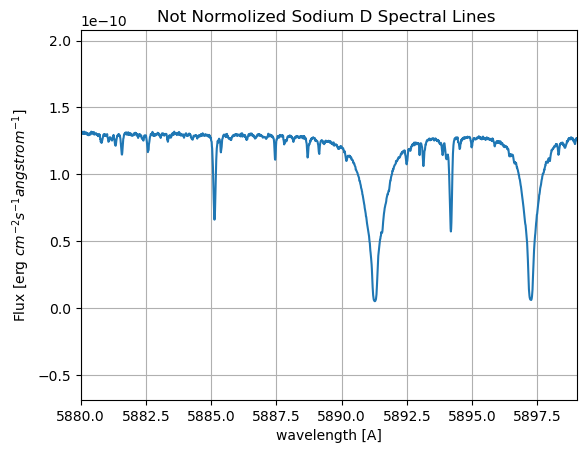

In [143]:
#This is the same as above, but "zooming in" on wavelength to get a look at Na D spectral lines (not normalized)
plt.plot(evt_data['WAVE'][0][:],evt_data['FLUX'][0][:])
plt.xlim(5880,5899) #the wavelengths we expect to see the Na D spectral lines 
plt.grid()
plt.xlabel('wavelength [A]')
plt.ylabel('Flux [erg $cm^{-2}$$s^{-1}$$angstrom^{-1}$]')
plt.title('Not Normolized Sodium D Spectral Lines ')

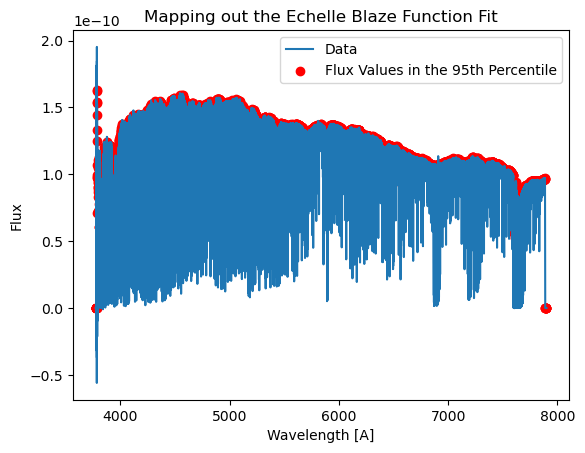

In [144]:
#This is for all data 
#dividing the data into 100 pixels
#finding the flux value in 95th percentile within each bin
#plotting the above flux values onto wavelength values
#dividing tauceti flux specctrum by the fit of 95th percentile flux values
#still NOT normalized

bin = 100
wave = evt_data['WAVE'][0][:]
flux = evt_data['FLUX'][0][:]
# this list will contain the indices corresponding to each of the 95th percentile flux values in each bin
indices = []

for i in np.arange((len(wave) - (bin)), step = bin):
    flux_values = []
    for j in np.arange(i, i + bin, step = 1):
        value = flux[j]
        flux_values = np.append(flux_values, value)
    # find the 95th percentile flux value: we use 95 to get the maximum flux value in general 
    # but avoid issues with cosmic rays and other emission lines
    flux_in_bin = np.percentile(flux_values, 95)
    # find the closest value in the flux array to the 95th percentile value
    absolute_difference_function = lambda list_value : abs(list_value - flux_in_bin)
    flux_in_bin = min(flux_values.tolist(), key=absolute_difference_function)
    index_in_bin = flux_values.tolist().index(flux_in_bin)
    index = i + index_in_bin
    indices = np.append(indices, index)

# these lists will contain the wavlength and flux values at each index in 'indices'
wl_values = []
fl_values = []

for index in indices:
    ind = int(index)
    wl_values = np.append(wl_values, wave[ind])
    fl_values = np.append(fl_values, flux[ind])
    
plt.plot(wave, flux, label = 'Data')
plt.scatter(wl_values, fl_values, color = 'red', label = 'Flux Values in the 95th Percentile')
# plt.xlim(5880,5899)
plt.title('Mapping out the Echelle Blaze Function Fit')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.legend()
plt.show()

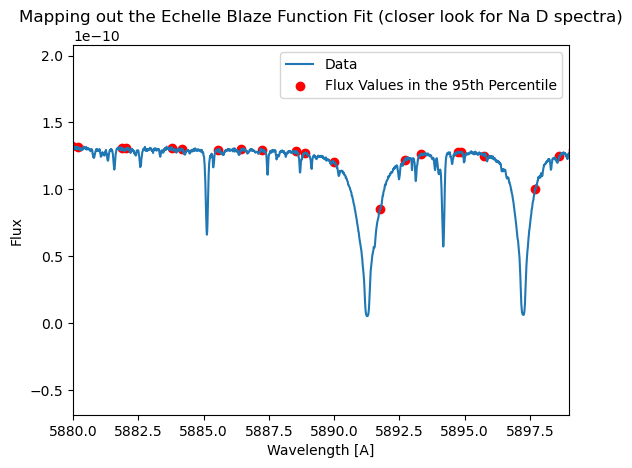

In [145]:
#let's do the same thing as above, but "zoom in" on wavelengths for Na D  
#still NOT normalized
plt.plot(wave, flux, label = 'Data')
plt.scatter(wl_values, fl_values, color = 'red', label = 'Flux Values in the 95th Percentile')
plt.xlim(5880,5899)
plt.title('Mapping out the Echelle Blaze Function Fit (closer look for Na D spectra)')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.legend()
plt.show()

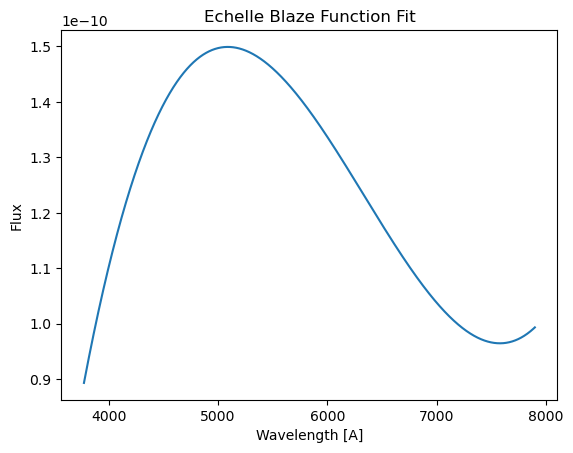

In [146]:
#plotting fl_values onto wl_values so that the length of the arrays match that of the tauceti spectrum. 
#setting s to 500000 to smooth the fit.

spl = splrep(wl_values, fl_values, s = 500000)
flux_fit = splev(wave, spl)
plt.plot(wave, flux_fit)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Echelle Blaze Function Fit')
plt.show()

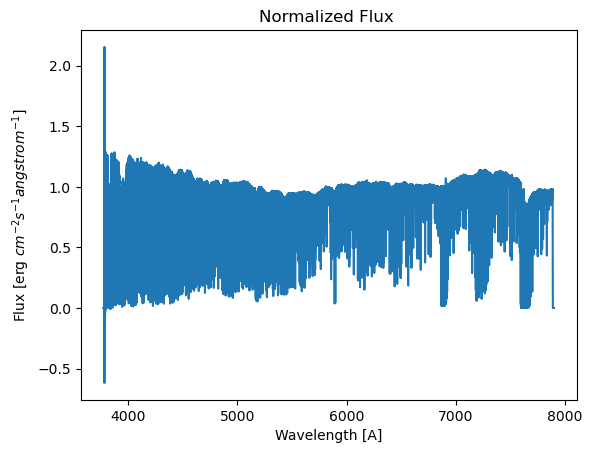

In [147]:
#for all data
#dividing the fit from data
#this is normalizing all of the data
first_normalized_flux = flux / flux_fit
plt.plot(wave, first_normalized_flux)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux [erg $cm^{-2}$$s^{-1}$$angstrom^{-1}$]')
plt.title('Normalized Flux ')
plt.show()

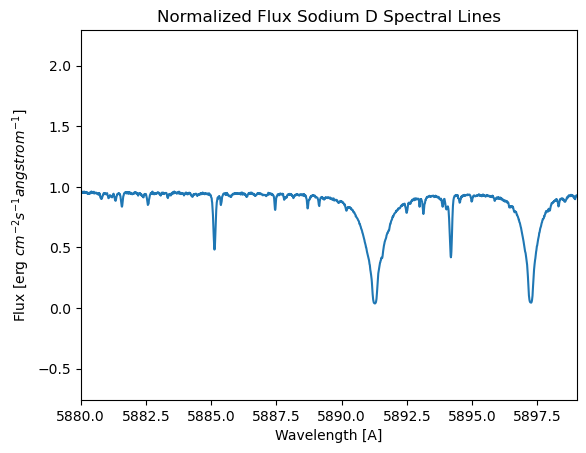

In [148]:
#same thing as above, but "zooming in" on wavelengths to see Na D 
plt.plot(wave, first_normalized_flux)
plt.xlim(5880,5899)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux [erg $cm^{-2}$$s^{-1}$$angstrom^{-1}$]')
plt.title('Normalized Flux Sodium D Spectral Lines')
plt.show()
#this looks good since it's around 1 on y-axis ==> what we want!

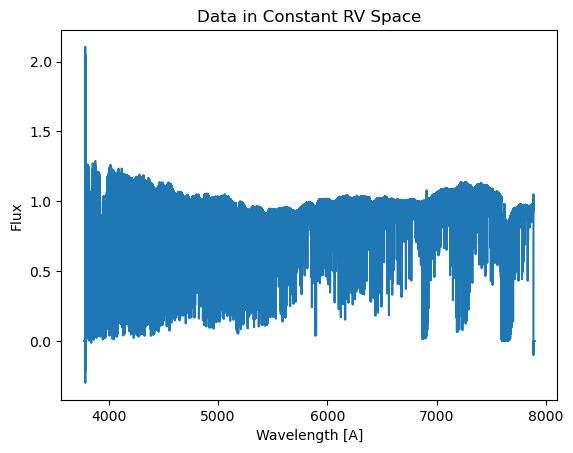

In [149]:
#Constant Radial Velocity Space
#plotting the normalized flux values onto the original wavelength grid
#creating a new wavelength grid that is log lambda spaced 
#then interpolate onto the new wavelength grid
#will create a spectrum that is in constant RV space
#it will allow for a straightforward calculation of the Doppler shift

#I'm not sure if this is correct
flux98 = np.percentile(first_normalized_flux, 98)
normalized_flux = first_normalized_flux 
f = scipy.interpolate.interp1d(wave, normalized_flux, kind='cubic')

#create an array of wavelength values that are spaced apart on a log scale (in order to change it to velocity)
dv = 1 # km/s
C = 299792.458 #km/s
wl_start = min(wave) + 0.2
wl_end = max(wave) - 0.2

CDELT1 = np.log10(dv/C +1) # wavelength grid step size

CRVAL1 = np.log10(wl_start)  # log of starting wavelength value
CRVALN = np.log10(wl_end)    # log of ending wavelength value 
NAXIS1 = (CRVALN - CRVAL1) / CDELT1  # total number of points

p = np.arange(NAXIS1) # array of total points
wl = 10 ** (CRVAL1 + CDELT1 * p)  # new array of wavelength values

# interpolate flux values onto log spaced wavelength grid
flux = f(wl)

#plotting new wavelength grid against flux values
#should look like as before, but this time wavelengths should be velocity spaced instead
plt.plot(wl, flux)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Data in Constant RV Space')
plt.show()

Text(0.5, 1.0, 'Data in Constant RV Space')

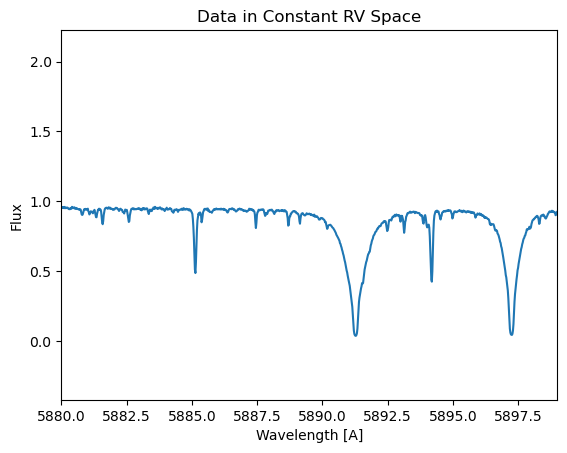

In [150]:
#same as above but for Na D 
plt.plot(wl, flux)
plt.xlim(5880,5899)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Data in Constant RV Space')
#comparing this with double normalization, we can see the difference in flux axis
#already seeing some difference

## NSO Solar Spectrum

In [151]:
#reading NSO data file
#downloaded the NSO fits file from the tutorial github
#I googled and it seems like we can "compare" stars spectrum with our own sun when it comes to spectrum analysis
solardata = fits.open('nso.fits')
solardata.info()
image_data = solardata[0].data # Get the data associated with the HDU, same as for a table
wl_temp = solardata[0].data
fl_temp = solardata[1].data
print(wl_temp)
print(fl_temp)

Filename: nso.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (1097840,)   float64   
  1                1 ImageHDU         6   (1097840,)   float64   
[ 3002.99584007  3002.99912     3003.00240993 ... 12499.25411987
 12499.27215958 12499.29018974]
[0.12356667 0.11316667 0.10346667 ... 0.97693333 0.9767     0.97636667]


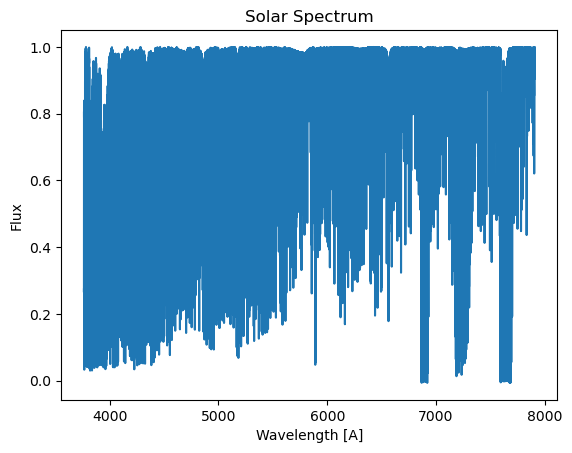

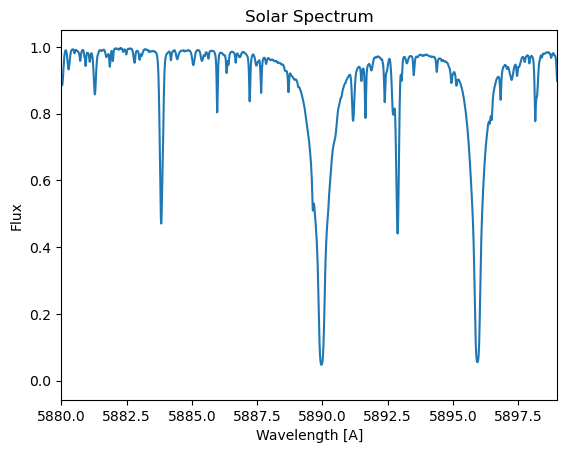

In [152]:
#trying to truncate the solar spectrum to match the wavelength range of tauceti data
#plotting all of the data
min_wl = min(wl) - 8
absolute_difference_function = lambda list_value : abs(list_value - min_wl)
w = min(wl_temp.tolist(), key = absolute_difference_function)
min_index = wl_temp.tolist().index(w)

max_wl = max(wl) + 8
absolute_difference_function = lambda list_value : abs(list_value - max_wl)
w = min(wl_temp.tolist(), key = absolute_difference_function)
max_index = wl_temp.tolist().index(w)

wl_syn_temp = wl_temp[min_index:max_index]
fl_syn_temp = fl_temp[min_index:max_index]

plt.plot(wl_syn_temp, fl_syn_temp)
# plt.xlim(5880,5899)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Solar Spectrum')
plt.show()

#zooming in to see for the sodium d lines
plt.plot(wl_syn_temp, fl_syn_temp)
plt.xlim(5880,5899)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Solar Spectrum')
plt.show()

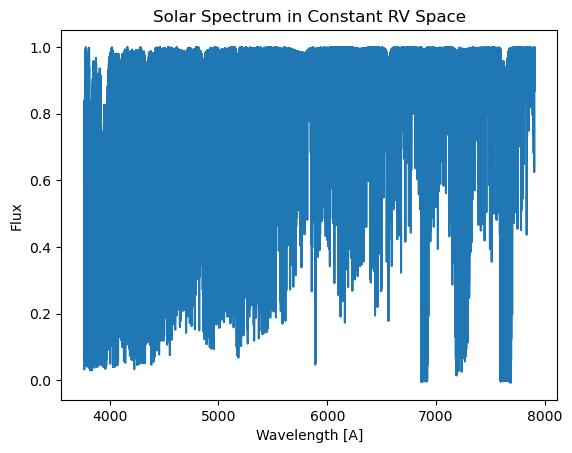

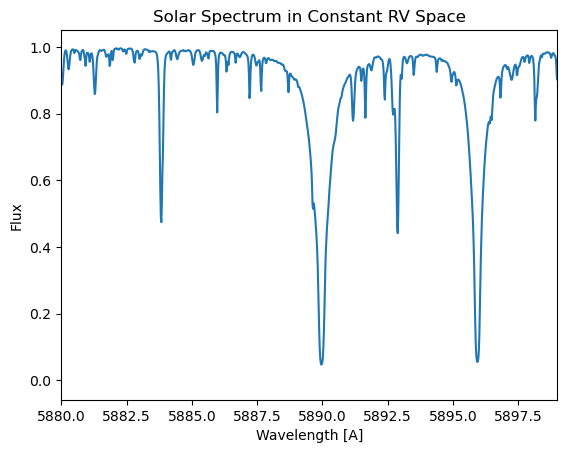

In [153]:
#regrid "synthetic" spectrum to be log lambda spaced (contant velocity).
#then plot the new wavelength grid against flux values (just like before) 
#should look the same as before
#the wavelengths are now velocity spaced (same as we did for tauceti spectrum) 
f = scipy.interpolate.interp1d(wl_syn_temp, fl_syn_temp, kind='cubic')

#create an array of wavelength values that are spaced apart on a log scale (in order to change it to velocity)
dv = 1 #km/s
C = 299792.458 #km/s
wl_start = min(wl_syn_temp) + 0.2
wl_end = max(wl_syn_temp) - 0.2

CDELT1 = np.log10(dv/C +1) #wavelength grid step size

CRVAL1 = np.log10(wl_start)  #log of starting wavelength value
CRVALN = np.log10(wl_end)    #log of ending wavelength value 
NAXIS1 = (CRVALN - CRVAL1) /CDELT1  #total number of points

p = np.arange(NAXIS1) #array of total points
wl_syn = 10 ** (CRVAL1 + CDELT1 * p)  #array of wavelength values

# interpolate flux values onto log spaced wavelength grid
fl_syn = f(wl_syn)


plt.plot(wl_syn, fl_syn)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Solar Spectrum in Constant RV Space')
plt.show()

#showing it for sodium d line
plt.xlim(5880,5899)
plt.plot(wl_syn, fl_syn)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Solar Spectrum in Constant RV Space')
plt.show()

The first value of the tauceti data is located at pixel 620 of the empirical spectrum.
tauceti is traveling toward Earth at 67 km/s. The Tauceti spectrum needs to be redshifted by 67 pixels. (Shift to left.)


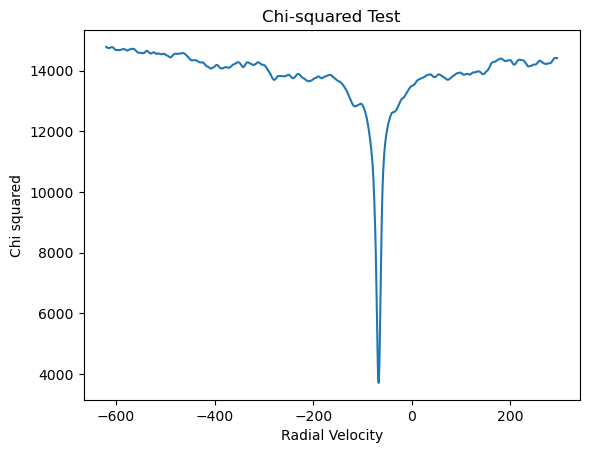

In [154]:
#Finding the current offset of tauceti spectrum and the empirical spectrum
min_wl = min(wl)
absolute_difference_function = lambda list_value : abs(list_value - min_wl)
w = min(wl_syn.tolist(), key = absolute_difference_function)
index = wl_syn.tolist().index(w)
print('The first value of the tauceti data is located at pixel ' + str(index) + ' of the empirical spectrum.')

#need to do a chi-squared test to figure out the offset of the data and the empirical spectrum
#chi-squared test scans the data against the synthetic spectrum 
#begins where the first pixels of each spectrum line up and end where the last pixels of each spectrum line up.
#chi squared also calculates the residual at each location. 
#when the two spectra line up, the residual will be minimized, resulting in a minimum in the chi-squared plot.
#defining the chi function
def chi(model, data):
    '''given two arrays of the same length,
    calculate chi squared'''
    return np.sum((data - model) ** 2)

chi_squared_values = []
indices = []

for i in np.arange(len(wl_syn) - len(wl)):
    syn_flux = fl_syn[i: i + len(wl)]
    chi_squared = chi(syn_flux, flux)
    chi_squared_values = np.append(chi_squared_values, chi_squared)
    indices = np.append(indices, i)
    
min_chi = min(chi_squared_values)
shifted_index = chi_squared_values.tolist().index(min_chi)

if (shifted_index - index) < 0:
    shift = index - shifted_index
    print(star + ' is traveling toward Earth at ' + str(shift) + ' km/s. The Tauceti spectrum needs to be redshifted by ' + str(shift) + ' pixels. (Shift to left.)')
    shift_dir = 'left'
else:
    shift = shifted_index - index
    print(star + ' is traveling away from Earth at ' + str(shift) + ' km/s. The Tauceti spectrum needs to be blueshifted by ' + str(shift) + ' pixels. (Shift to right.)')
    shift_dir = 'right'

plt.plot(indices - index, chi_squared_values)
plt.xlabel('Radial Velocity')
plt.ylabel('Chi squared')
plt.title('Chi-squared Test')
plt.show()

#I'm not sure about the final result of chi-squared test. Because when I try to zoom in for the sodium D, 
#there is nothing to show. I guess it makes sense, since it doesn't continue to that wavelength.
#might need to do more investigation on this later

#interesting result because now the y-axis values seem higher than the double normalization
#the shape seems to be the same
#there's a raise in chi-squared 


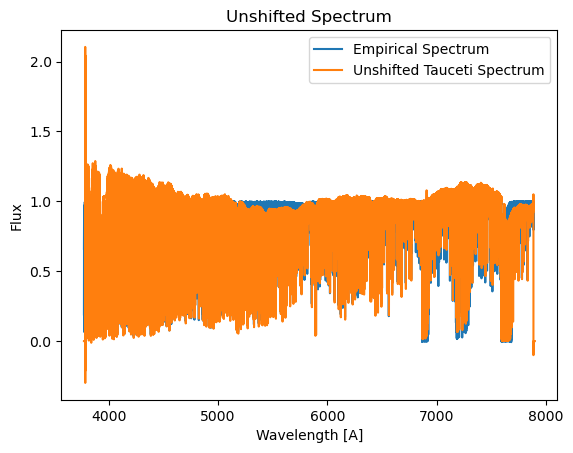

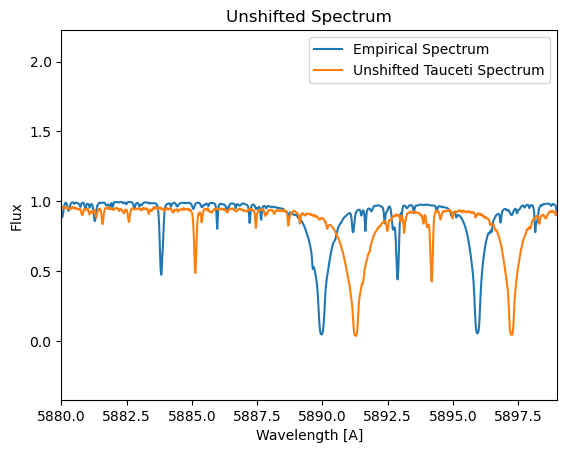

In [155]:
#plot of the unshifted tauceti spectrum against the empirical spectrum.
wl_syn_plot = wl_syn[index:-index]
fl_syn_plot = fl_syn[index:-index]

if shift_dir == 'left':
    shifted_wl = wl[:-shift]
    shifted_fl = flux[shift:]
else:
    shifted_wl = wl[shift:]
    shifted_fl = flux[:-shift]

plt.plot(wl_syn_plot, fl_syn_plot, label = 'Empirical Spectrum')
plt.plot(wl, flux, label = 'Unshifted Tauceti Spectrum')

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Unshifted Spectrum')
# plt.xlim(5880,5899)
plt.legend()
plt.show()

#for Na D
plt.plot(wl_syn_plot, fl_syn_plot, label = 'Empirical Spectrum')
plt.plot(wl, flux, label = 'Unshifted Tauceti Spectrum')

plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Unshifted Spectrum')
plt.xlim(5880,5899)
plt.legend()
plt.show()
#the tutorial continues with "zooming in" to see better, but I'm sticking with Na D so I skipped that part of tutorial
#the graph below already shows the difference


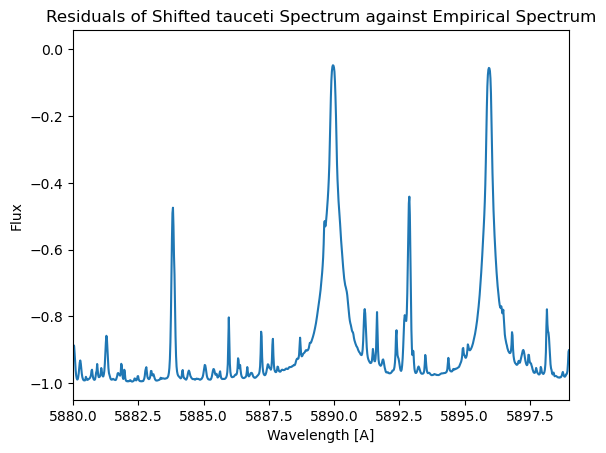

The average residual is -0.8631266214785659


In [156]:
#plotting residuals
residuals_unshifted = flux[len(wl_syn_plot)] - fl_syn_plot
plt.xlim(5880,5899)
plt.plot(wl_syn_plot, residuals_unshifted)
 
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.title('Residuals of Shifted tauceti Spectrum against Empirical Spectrum')

plt.show()

print('The average residual is ' + str(np.average(residuals_unshifted)))
#the residual is stil negative while the tutorial's positive
#when the residual is negative then it means the predicted value is too high
#might need more investigation on this
 

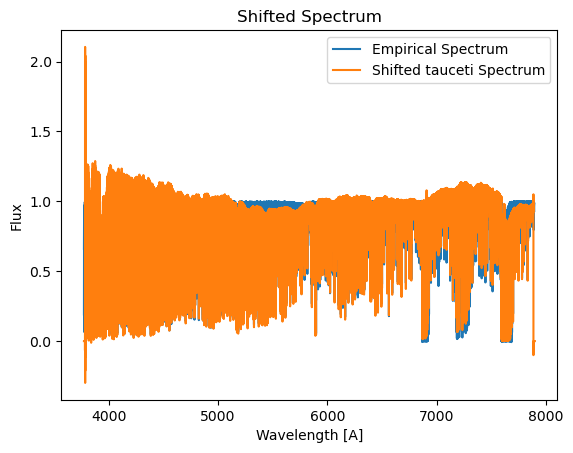

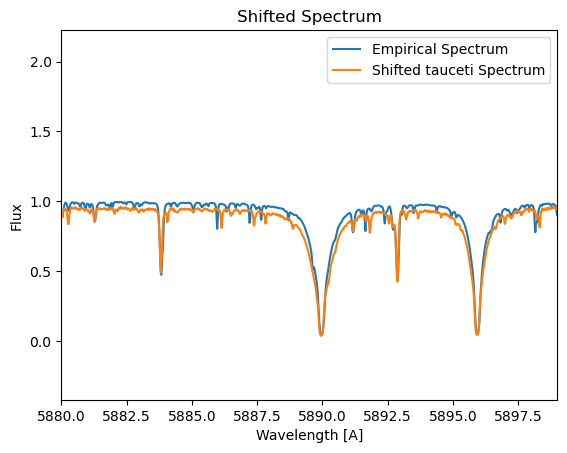

In [157]:
#plot of the shifted tauceti spectrum against the empirical spectrum
#it should line up with the empirical spectrum much better

plt.plot(wl_syn_plot, fl_syn_plot, label = 'Empirical Spectrum')
plt.plot(shifted_wl, shifted_fl, label = 'Shifted tauceti Spectrum')

plt.title('Shifted Spectrum')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.legend()
plt.show()

#since above graph is not clear or much informative, I'm going to show the Na D
plt.plot(wl_syn_plot, fl_syn_plot, label = 'Empirical Spectrum')
plt.plot(shifted_wl, shifted_fl, label = 'Shifted tauceti Spectrum')
plt.xlim(5880,5899)
plt.title('Shifted Spectrum')
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.legend()
plt.show()


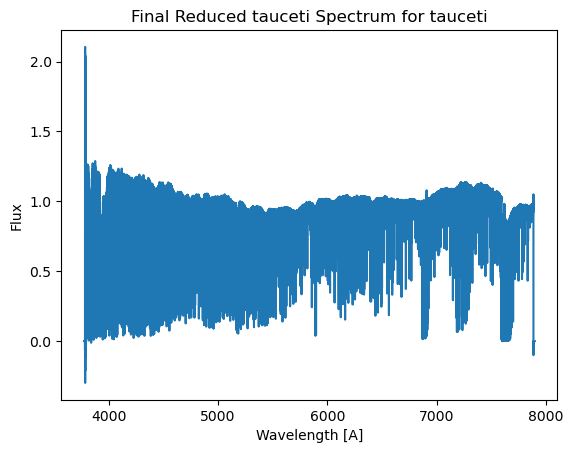

In [158]:
plt.plot(shifted_wl, shifted_fl)
# plt.xlim(5880,5899)
plt.title('Final Reduced tauceti Spectrum for ' + star)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.show()


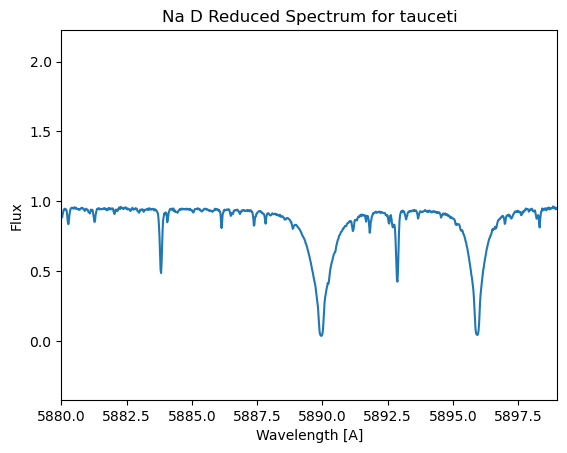

In [159]:
element = 'Na D '
plt.plot(shifted_wl, shifted_fl)
plt.xlim(5880,5899)
plt.title(element + 'Reduced Spectrum for ' + star)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.show()

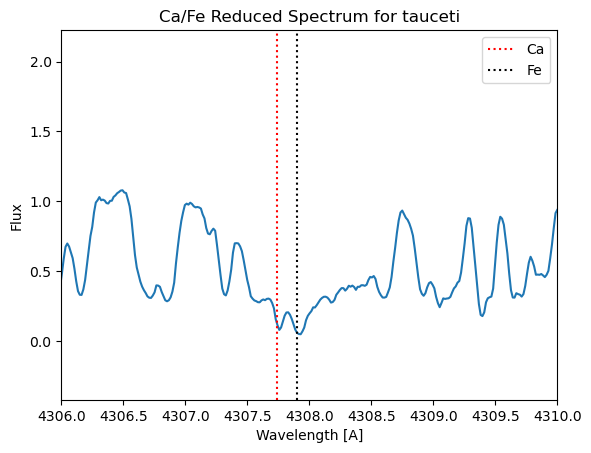

In [368]:
element = 'Ca/Fe '

plt.plot(shifted_wl, shifted_fl)
#4307.74 Ca
#4307.9 Fe
plt.xlim(4306 ,4310)
plt.title(element + 'Reduced Spectrum for ' + star)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.axvline(x=4307.74, color = 'r', ls = ':', label = 'Ca')
plt.axvline(x=4307.9, color = 'black', ls = ':', label = 'Fe')
plt.legend()
plt.show()

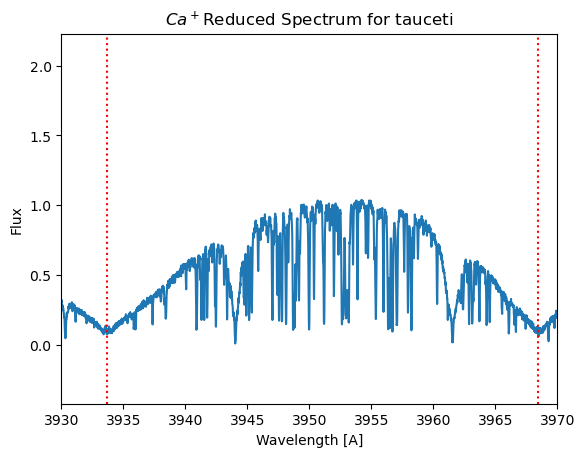

In [161]:
element = '$Ca^+$'

plt.plot(shifted_wl, shifted_fl)
#3933.66
#3968.47
plt.xlim(3930 ,3970)
plt.title(element + 'Reduced Spectrum for ' + star)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.axvline(x=3933.66, color = 'r', ls = ':')
plt.axvline(x=3968.47, color = 'r', ls = ':')
# plt.legend()
plt.show()

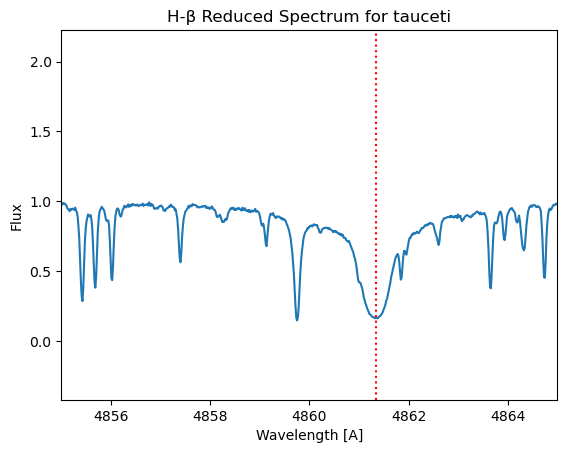

In [162]:
element = 'H-β '

plt.plot(shifted_wl, shifted_fl)
#4861.34
plt.xlim(4855 ,4865)
plt.title(element + 'Reduced Spectrum for ' + star)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.axvline(x=4861.34, color = 'r', ls = ':')
# plt.legend()
plt.show()

Text(0, 0.5, 'Flux')

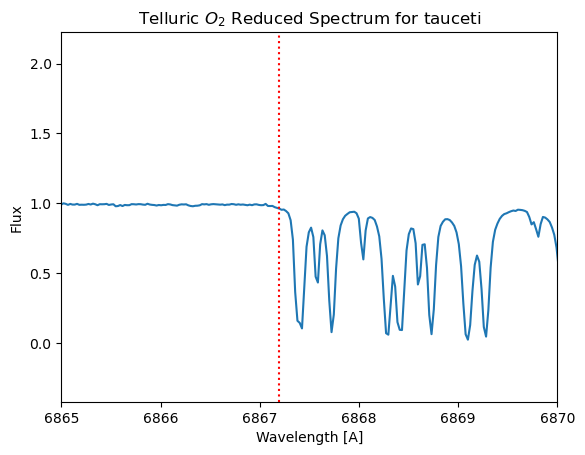

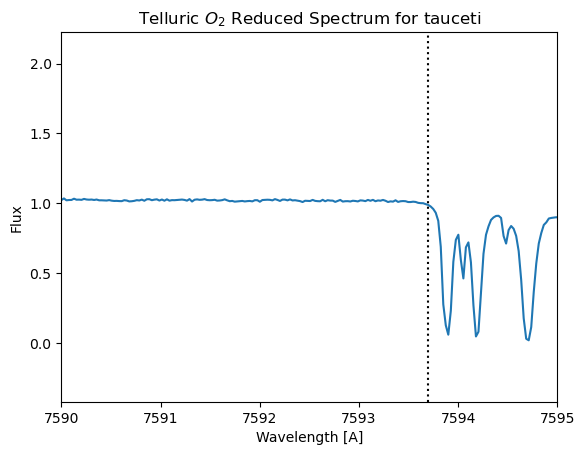

In [163]:
element = 'Telluric $O_2$ '

plt.plot(shifted_wl, shifted_fl)
#6867.19
#7593.70


plt.xlim(6865 ,6870)
plt.title(element + 'Reduced Spectrum for ' + star)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')
plt.axvline(x=6867.19, color = 'r', ls = ':')

# plt.legend()
plt.figure()
plt.plot(shifted_wl, shifted_fl)
plt.xlim(7590 ,7595)
plt.axvline(x=7593.70, color = 'black', ls = ':')
plt.title(element + 'Reduced Spectrum for ' + star)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')

Text(0, 0.5, 'Flux')

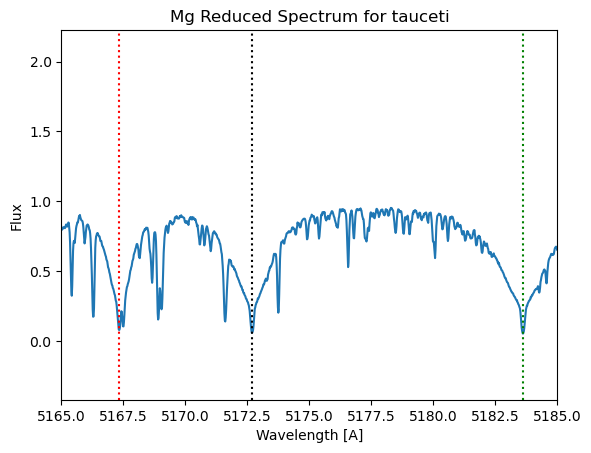

In [164]:
element = 'Mg '

plt.plot(shifted_wl, shifted_fl)
#5167.33
#5172.70
#5183.62


plt.xlim(5165 ,5185)
plt.axvline(x=5167.33, color = 'r', ls = ':')
plt.axvline(x=5172.70, color = 'black', ls = ':')
plt.axvline(x=5183.62, color = 'g', ls = ':')
plt.title(element + 'Reduced Spectrum for ' + star)
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux')

94209 95367
5165.004570104507
[0.80843836 0.79653687 0.80260833 ... 0.67559365 0.67457831 0.67196027]


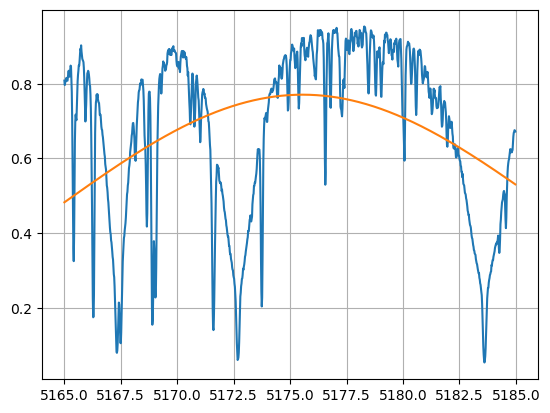

In [382]:
wavelength = shifted_wl
flux = shifted_fl

def gaussian(x, amplitude, mean, sigma):
    #sigma should be the width of point-spread function (PSF)
    return amplitude * np.exp(-0.5 * ((x - mean) / sigma)**2)

x = np.linspace(5165, 5185, 100)



index0 = np.argwhere(wavelength >= 5165)[0][0]
index1 = np.argwhere(wavelength <=5185)[-1][0]
print(index0, index1)
print(wavelength[index0])
cutwave = wavelength[index0:index1]
cutflux = flux[index0:index1]
print(cutflux)
#make gaussian fit ==>if equally spaced in wavelength
#go from wavelength to radial velocity ==>equally spaced in velocity
#why shifting if they're not 

popt, pcov = curve_fit(gaussian, cutwave, cutflux, p0 = np.array([1, 5172.5,1]))
plt.plot(cutwave, cutflux)
plt.grid()
plt.plot(cutwave, gaussian(cutwave, *popt))
# plt.xlim(5167.5 ,5170)
# plt.ylim(0,1)
